In [5]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra
from pyiga import assemble
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists
import itertools
from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)
import numba as nb    
from numba import njit

Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
class IetiDP:
    def __init__(self, MP, dir_data, neu_data=None, elim=True):
        self.space = MP
        self.elim=elim
        
        self.dir_idx=dict()
        self.dir_vals=dict()
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        for key in dir_data:
            for p,b in self.space.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(self.dir_idx[p], return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
        
        if self.elim:
            Basis=MP.Basis.tocsc()
            #self.Basis, self.N, self.B  = ieti_cy.pyx_compute_decoupled_coarse_basis(Basis, MP.numpatches)
            dofs=dict()
            constr=[]
            for p in range(MP.numpatches):
                idx_per_col = [Basis.indices[Basis.indptr[c]:Basis.indptr[c+1]] for c in range(Basis.shape[1])]
                dofs[p] = np.where([np.any((i<MP.N_ofs[p+1]) & (i>=MP.N_ofs[p])) for i in idx_per_col])[0]
            print(dofs)
            N = [len(dofs_) for dofs_ in dofs.values()]
            N_ofs = np.cumsum([0]+N)

            self.Basisk=[Basis[MP.N_ofs[p]:MP.N_ofs[p+1],:][:,dofs[p]] for p in range(MP.numpatches)]

            J1=[]
            J2=[]
            for (p1,b1,_),(p2,b2,_),_ in MP.intfs:
                #print(np.intersect1d(dofs[p1],dofs[p2]))
                J1.append([np.where(dofs[p1]==g)[0][0]+N_ofs[p1] for g in np.intersect1d(dofs[p1],dofs[p2])])
                J2.append([np.where(dofs[p2]==g)[0][0]+N_ofs[p2] for g in np.intersect1d(dofs[p1],dofs[p2])])

            J1=np.concatenate(J1)
            J2=np.concatenate(J2)
            data=np.r_[np.ones(len(J1)),-np.ones(len(J2))]
            I=np.r_[np.arange(len(J1)),np.arange(len(J2))]
            J = np.r_[J1,J2]
            self.B = scipy.sparse.coo_matrix((data,(I,J)),(len(J1),sum(N))).tocsr()
        else:
            self.Basisk = [scipy.sparse.identity(MP.N[p]) for p in range(MP.numpatches)]
            self.B = MP.Constr
            
        self.N = [Ba.shape[1] for Ba in self.Basisk]
        self.N_ofs = np.cumsum([0]+self.N)
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]
        self.Basis=scipy.sparse.block_diag(self.Basisk)
        self.P2Gk =[]
        
        for p in range(self.space.numpatches):
            X = self.Basisk[p].tocoo()
            idx = np.where(np.isclose(X.data,1))
            X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
            D = (X.T@self.Basisk[p]).sum(axis=1).A.ravel()
            #assert all(abs(D)>1e-12), 'D has zeros.'
            #S = scipy.sparse.spdiags(1/D,[0],len(D),len(D))
            self.P2Gk.append(X.T)
            I = np.zeros(self.Basisk[p].shape[0])
            if p in self.dir_idx:
                I[self.dir_idx[p]] = 1
                self.dir_idx[p] = np.where(np.isclose(self.P2Gk[p]@I,1))[0]
        
        self.P2G = scipy.sparse.block_diag(self.P2Gk)
        if len(self.dir_idx)>0:
            self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        else:
            self.global_dir_idx = np.array([])
        self.free_dofs = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx)
        self.free_dofs_pp = [np.arange(self.N[p]) if p not in self.dir_idx else np.setdiff1d(np.arange(self.N[p]),self.dir_idx[p]) for p in range(self.space.numpatches)]
        
        #self.B = self.B @ scipy.sparse.block_diag(self.Basisk)
        
        nnz_per_col = self.B.getnnz(axis=0)
        self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.skeleton = np.union1d(self.intfs, self.global_dir_idx)
        
        self.Rbb = []
        self.Rii = []
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask = np.zeros(self.N[p], dtype=bool)
            nnz_per_col = self.Bk[p].getnnz(axis=0)
            if p in self.dir_idx:
                intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.dir_idx[p])
            else:
                intfs = np.where(nnz_per_col > 0)[0]
            mask[intfs]=True
            if p in self.dir_idx:
                mask[self.dir_idx[p]]=False
            self.Rbb.append(Id[mask].tocsc())
            mask = np.ones(self.N[p], dtype=bool)
            mask[intfs]=False
            if p in self.dir_idx:
                mask[self.dir_idx[p]]=False
            self.Rii.append(Id[mask].tocsc())
            
#         Id = scipy.sparse.eye(self.Basis.shape[0], format='csr')
#         mask = np.zeros(self.Basis.shape[0], dtype=bool)
#         mask[self.intfs] = True
#         mask[self.global_dir_idx]=False
#         self.Rbb = Id[mask].tocsc()
#         mask = np.ones(self.Basis.shape[0], dtype=bool)
#         mask[self.skeleton] = False
#         self.Rii = Id[mask].tocsc()
        
        #self.B = self.B[:,self.free_dofs]

        #self.dir_ofs = np.cumsum(np.array([len(np.unique(idx[p])) for p in range(MP.numpatches)]))
        
    def assemble(self, problem, f):
        Ak = [Ba.T @ assemble.assemble(problem, kvs, bfuns=[('u',1), ('v',1)], geo=geo)@Ba for Ba, ((kvs, geo),_) in zip(self.Basisk, self.space.mesh.patches)]
        A = scipy.sparse.block_diag(Ak, format='csr')
        rhsk = [Ba.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f).ravel() for Ba, ((kvs, geo),_) in zip(self.Basisk,self.space.mesh.patches)]

        # self.Abb = self.Rbb.dot(A).dot(self.Rbb.T)
        # self.Aii = self.Rii.dot(A).dot(self.Rii.T)
        # self.Abi = self.Rbb.dot(A).dot(self.Rii.T)
        # self.Aib = self.Abi.T
        
        BCRestr = {p:assemble.RestrictedLinearSystem(Ak[p], rhsk[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        self.rhsk = [rhsk[p] if p not in self.dir_idx else BCRestr[p].b for p in range(self.space.numpatches)]
        self.Ak = [Ak[p] if p not in self.dir_idx else BCRestr[p].A for p in range(self.space.numpatches)]
        self.A = scipy.sparse.block_diag(self.Ak)
        # self.A = BCRestr.A
        # self.rhs = BCRestr.b
        
    def construct_primal_constraints_elim(self, redundant=False):
        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        Nodes = self.space.get_nodes()
        self.eliminate_constraints = np.array([], dtype=int)
        Prim = {}
        i=0
        
        for key in Nodes:
            if isinstance(key,int32):
                dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                Prim[i] = (dofs,np.ones(len(dofs)))
                i+=1
            else:
                constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                dofs_coarse = self.Basis.tocsr()[Nodes[key][1],:].indices
                dofs=[]
                for dof in dofs_coarse:
                    found_dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                    dofs.append(found_dofs)
                Prim[i] = (np.concatenate(dofs),np.repeat(coeffs,len(found_dofs)))
                i+=1

        loc_c_prim = np.concatenate([Prim[key][0] for key in Prim])
        coeffs = np.concatenate([Prim[key][1] for key in Prim])
        loc_c_prim_idx = np.repeat(np.arange(len(Prim)),[len(Prim[i][0]) for i in Prim])
        p_idx = [(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1]) for p in range(self.space.numpatches)]
        Prim_pp = {p : (loc_c_prim[p_idx[p]],coeffs[p_idx[p]],loc_c_prim_idx[p_idx[p]]) for p in range(self.space.numpatches)}

        for p in range(MP.numpatches):
            c_primal_free = Prim_pp[p][0] - self.N_ofs[p]
            data = Prim_pp[p][1]
            idx = np.bincount(Prim_pp[p][2])
            idx = idx[idx>0]
            rows = np.repeat(np.arange(len(idx)),idx)
            cols = c_primal_free
            ck = coo_matrix((data, (rows, cols)),(len(idx),self.N[p])).tocsc()
            ck = ck[:,self.free_dofs_pp[p]]
            self.Ck.append(ck.tocsr())
            m, n = ck.shape[0], len(Prim)
            jj = np.unique(Prim_pp[p][1])
            self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
            
            if not redundant:
                nnz_per_row = self.B[:,self.Prim_pp[p][0]].getnnz(axis=1)
                result = np.where(nnz_per_row > 0)[0]
                self.eliminate_constraints = np.union1d(result, self.eliminate_constraints)
        
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
    
    def construct_primal_constraints_elim_fat(self, redundant=False):
        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        self.eliminate_constraints = np.array([], dtype=int)
        Nodes=self.space.get_nodes()
        self.Prim = {}
        
        total_dofs=set()
        i=0
        for key in Nodes:
            if isinstance(key,tuple):
                dofs = self.Basis.tocsr()[Nodes[key][1],:].indices
                #print(dofs)
                for dof in dofs:
                    if dof not in total_dofs:
                        total_dofs.add(dof)
                        self.Prim[i] = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                        i+=1
            else:
                self.Prim[i] = self.Basis.tocsr()[Nodes[key][0],:].indices
                i+=1
        loc_c_prim = np.concatenate([self.Prim[key] for key in self.Prim])
        #print(loc_c_prim)
        loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i]) for i in self.Prim])
        self.Prim_pp = {p : (loc_c_prim[(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1])],loc_c_prim_idx[(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1])]) for p in range(self.space.numpatches)}
        
        for p in range(len(self.space.mesh.patches)):
            c_primal_free = self.Prim_pp[p][0] - self.N_ofs[p]
            #print(c_primal_free)
            data = np.ones(len(c_primal_free))
            rows = np.arange(len(c_primal_free))
            cols = c_primal_free
            ck = coo_matrix((data, (rows, cols)),(len(c_primal_free),self.N[p])).tocsc()
            ck = ck[:,self.free_dofs_pp[p]]
            self.Ck.append(ck.tocsr())
            m, n = ck.shape[0], len(self.Prim)
            jj = self.Prim_pp[p][1]
            self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))

            if not redundant:
                nnz_per_row = self.B[:,self.Prim_pp[p][0]].getnnz(axis=1)
                result = np.where(nnz_per_row > 0)[0]
                self.eliminate_constraints = np.union1d(result, self.eliminate_constraints)
            
        #self.eliminate_constraints = np.unique(self.B.tocsc()[:,loc_c_prim].indices)
        #self.eliminate_constraints=np.array([])
        #print(self.eliminate_constraints)
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_constraints(self, redundant=False, fat=True):
        if self.elim:
            if fat:
                self.construct_primal_constraints_elim_fat(redundant = redundant)
            else:
                self.construct_primal_constraints_elim(redundant = redundant)
            return;

        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        self.eliminate_constraints = np.array([], dtype=int)
        Nodes=self.space.get_nodes()
        self.Prim = {}
        
        self.Prim = {i: val for i,val in enumerate(self.space.get_nodes().values())}
        loc_c_prim = np.concatenate([Nodes[key][0] for key in Nodes])
        loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i][0]) for i in self.Prim])
        self.cpp = {p : (loc_c_prim[(loc_c_prim >= self.space.N_ofs[p]) & (loc_c_prim < self.space.N_ofs[p+1])],loc_c_prim_idx[(loc_c_prim >= self.space.N_ofs[p]) & (loc_c_prim < self.space.N_ofs[p+1])]) for p in range(self.space.numpatches)}
        self.tpp = {p : {key:val for key,val in self.Prim.items() if len(val)>1 and all((val[1] >= self.space.N_ofs[p]) & (val[1] < self.space.N_ofs[p+1]))} for p in range(self.space.numpatches)}
        
        for p in range(len(self.space.mesh.patches)):
            c_primal_free = self.cpp[p][0] - self.space.N_ofs[p]
            #print(self.cpp[p][0])
            if not redundant:
                nnz_per_row = 1*(self.space.Constr[:,self.cpp[p][0]]==1).getnnz(axis=1)
                result = np.where(nnz_per_row > 0)[0]
                self.eliminate_constraints = np.union1d(result, self.eliminate_constraints)

            data = np.ones(len(c_primal_free))
            rows = np.arange(len(c_primal_free))
            cols = c_primal_free
            ck = coo_matrix((data, (rows, cols)),(len(c_primal_free),self.space.N[p])).tocsc()

            V = []
            for t in self.tpp[p]:
                constr = (self.space.Constr.tocsc()[:,self.tpp[p][t][0][0]]==1).indices
                if not redundant:
                    self.eliminate_constraints = np.union1d(constr, self.eliminate_constraints)
                X = self.space.Constr[constr,:][:,self.space.N_ofs[p]:self.space.N_ofs[p+1]].tocsr()
                V.append(X[X.getnnz(axis=1)>0,:])
            ck = (scipy.sparse.vstack([ck]+V)@self.Basisk[p]).tocsc()

            ck = ck[:,self.free_dofs_pp[p]]
            self.Ck.append(ck.tocsr())
            m, n = ck.shape[0], len(Nodes)
            jj = np.concatenate([self.cpp[p][1],np.array(list(self.tpp[p].keys()), dtype=int)])
            #print(m, jj)
            self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
            #print(ck.A)
            
        #self.eliminate_constraints = np.unique(self.B.tocsc()[:,loc_c_prim].indices)
        #self.eliminate_constraints=np.array([])
        #print(self.eliminate_constraints)
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_basis(self):
        PsiK=[]
        
        for p in range(len(self.space.mesh.patches)):
            a = self.Ak[p]
            c = self.Ck[p]
            AC = scipy.sparse.bmat(
            [[a, c.T],
             [c,  None   ]], format='csr')
            RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
            psi = scipy.sparse.linalg.spsolve(AC, RHS)
            psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
            if psi.ndim==1: psi=psi[:,None]
            PsiK.append(psi@self.Rk[p])

        self.Psi=np.vstack(PsiK)
        
    def compute_F(self):
        B = self.B[:,self.free_dofs]
        #keep= np.arange(B.shape[0])
        keep = np.where(B.getnnz(axis=1)>0)[0]
        B=B[keep,:]
        idx_p = [(self.free_dofs < self.N_ofs[p+1]) & (self.free_dofs >= self.N_ofs[p]) for p in range(self.space.numpatches)]
        Bk = [B[:,idx_p[p]] for p in range(self.space.numpatches)]
        #Bk = [b[np.where(b.getnnz(axis=1)>0)[0]] for b in Bk]
        self.Bk_ = [aslinearoperator(scipy.sparse.bmat([[b,np.zeros((b.shape[0],self.Ck[p].shape[0]))]], format='csr')) for p,b in enumerate(Bk)] 
        PTAP = self.Psi.T@self.A@self.Psi
        PTBT = self.Psi.T@B.T
        BP   = B@self.Psi
        
        rhs = np.concatenate(self.rhsk)
        rhsk_ = [np.concatenate([f,np.zeros(self.Ck[p].shape[0])]) for p,f in enumerate(self.rhsk)]
        
        loc_solver = [solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True) for a,c in zip(self.Ak, self.Ck)]
        F1 = aslinearoperator(BP@solvers.make_solver(PTAP, spd=True, symmetric=True).dot(BP.T)) 
        F2 = sum([b@Ak_inv.dot(b.T) for b, Ak_inv in zip(self.Bk_,loc_solver)])

        b1 = BP@solvers.make_solver(PTAP, spd=True, symmetric=True).dot(self.Psi.T@rhs)
        b2 = np.sum([b@Ak_inv@f for b, Ak_inv,f in zip(self.Bk_, loc_solver, rhsk_)],axis=0)
        
        return F1+F2, b1+b2
    
    def MsD(self, new=False):
        B = self.B[:,self.free_dofs]
        keep = np.where(B.getnnz(axis=1)>0)[0]
        B = B[keep,:]
        Bk = [self.Bk[p][keep,:][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)] 
        Rb = [self.Rbb[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]
        Ri = [self.Rii[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]
        self.B_gamma = scipy.sparse.hstack([Bk[p]@Rb[p].T for p in range(self.space.numpatches)])

        Abb = [aslinearoperator(Rb[p]@self.Ak[p]@Rb[p].T) for p in range(self.space.numpatches)]
        Aii = [Ri[p]@self.Ak[p]@Ri[p].T for p in range(self.space.numpatches)]
        Abi = [aslinearoperator(Rb[p]@self.Ak[p]@Ri[p].T) for p in range(self.space.numpatches)]
        
        self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(Abb,Abi,Aii)]
        ofs = np.cumsum([0]+[s.shape[0] for s in self.S])
        #print(self.S)
        
        if self.elim:
            D = self.B_gamma.getnnz(axis=0)
            D = 1/(1+D)
            self.D = scipy.sparse.diags(D, format='csr')
        else:
            if new:
                R = 1*(self.B_gamma==1).T
                self.D = R@R.T
            # t = time.time()
            # D = np.linalg.pinv(self.B_gamma.A)
            # D[abs(D)<1e-16]=0.0
            # print("computing the pseudoinverse and pruning took " + str(time.time()-t) + " seconds.")
            # D=scipy.sparse.csr_matrix(D)
            # self.D=D@D.T
            else: 
                D = abs(I.B_gamma).sum(axis=0).A[0]
                D = 1/(1+D)
                self.D = scipy.sparse.diags(D, format='csr')
        self.BgD = self.B_gamma@self.D
        # for p in range(self.space.numpatches):
        #     print(self.BgD[:,ofs[p]:ofs[p+1]].shape, self.S[p].shape, self.BgD[:,ofs[p]:ofs[p+1]].T.shape)
        return sum([aslinearoperator(self.BgD[:,ofs[p]:ofs[p+1]])@self.S[p].dot(aslinearoperator(self.BgD[:,ofs[p]:ofs[p+1]].T)) for p in range(self.space.numpatches)])

In [7]:
def checkerboard(deg,N,k):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((2,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    geometry.unit_square().translate((2,1)),
    geometry.unit_square().translate((0,2)),
    geometry.unit_square().translate((1,2)),
    geometry.unit_square().translate((2,2)),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==1})
    return M

In [8]:
def Lshape(deg,N,depth=3):
    patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.unit_square())]
    M = topology.PatchMesh(patches)

    for i in range(depth):
        M.h_refine({0:None})
    return M

In [14]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
deg=1
elim=True

for i in range(3,4):
    M = checkerboard(deg,2**i,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
    t=time.time()
    I = IetiDP(MP, dir_data = {0:g}, elim=elim)
    

setting up constraints took 0.023258209228515625 seconds.
Basis setup took 0.009887933731079102 seconds
{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]), 1: array([  8,  17,  26,  35,  44,  53,  62,  71,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,

setting up constraints took 5.9604644775390625e-06 seconds.
Basis setup took 0.0013647079467773438 seconds
Refinement took 0.0023899078369140625 seconds for 1 patches.
setting up constraints took 0.0036721229553222656 seconds.
Basis setup took 0.006747007369995117 seconds
Refinement took 0.0021648406982421875 seconds for 1 patches.
setting up constraints took 0.010409116744995117 seconds.
Basis setup took 0.0058062076568603516 seconds
Refinement took 0.00362396240234375 seconds for 2 patches.
setting up constraints took 0.015062332153320312 seconds.
Basis setup took 0.008780479431152344 seconds


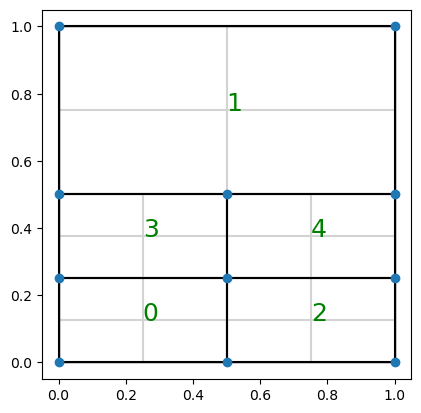

In [13]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
deg=2
N=2

patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.unit_square())]
M = topology.PatchMesh(patches)
MP = assemble.Multipatch(M, automatch=True)
MP.h_refine({0:0})
MP.h_refine({0:1})
# MP.h_refine({0:0})
# MP.h_refine({0:1})
MP.h_refine({0:0,2:0})
#MP.h_refine({1:1})
#MP.h_refine({1:1})
MP.set_dirichlet_boundary({0:g})
MP.mesh.draw(patch_idx=1,nodes=1,knots=1)

In [17]:
I = IetiDP(MP, dir_data = {0:g}, elim=True)
I.assemble(problem='(inner(grad(u),grad(v)))* dx',f=lambda x,y: 1.)
I.construct_primal_constraints(redundant=True, fat=False)
I.construct_primal_basis()

In [510]:
Ck = []
Rk = []
kvs = MP.mesh.kvs
geos = MP.mesh.geos
Basis = I.Basis
Basisk=I.Basisk
#eliminate_constraints = np.array([], dtype=int)
Nodes=MP.get_nodes()
#Prim = {i: val for i,val in enumerate(Nodes.values())}
Prim = {}
#total_dofs=set()
i=0
for key in Nodes:
    if isinstance(key,int32):
        dofs = Basis.tocsr()[Nodes[key][0],:].indices
        Prim[i] = (dofs,np.ones(len(dofs)))
        i+=1
    else:
        constr = (MP.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
        coeffs = abs(MP.Constr[constr,:][:,Nodes[key][1]].data)
        dofs_coarse = Basis.tocsr()[Nodes[key][1],:].indices
        dofs=[]
        for dof in dofs_coarse:
            found_dofs = np.unique(I.B.tocsr()[I.B.tocsc()[:,dof].indices,:].indices)
            dofs.append(found_dofs)
        Prim[i] = (np.concatenate(dofs),np.repeat(coeffs,len(found_dofs)))
        i+=1
            
loc_c_prim = np.concatenate([Prim[key][0] for key in Prim])
coeffs = np.concatenate([Prim[key][1] for key in Prim])
loc_c_prim_idx = np.repeat(np.arange(len(Prim)),[len(Prim[i][0]) for i in Prim])
p_idx = [(loc_c_prim >= I.N_ofs[p]) & (loc_c_prim < I.N_ofs[p+1]) for p in range(MP.numpatches)]
Prim_pp = {p : (loc_c_prim[p_idx[p]],coeffs[p_idx[p]],loc_c_prim_idx[p_idx[p]]) for p in range(MP.numpatches)}
        
for p in range(MP.numpatches):
    c_primal_free = Prim_pp[p][0] - I.N_ofs[p]
    data = Prim_pp[p][1]
    idx = np.bincount(Prim_pp[p][2])
    idx=idx[idx>0]
    rows = np.repeat(np.arange(len(idx)),idx)
    cols = c_primal_free
    ck = coo_matrix((data, (rows, cols)),(len(idx),I.N[p])).tocsc()
    #ck = ck[:,self.free_dofs_pp[p]]
    Ck.append(ck.tocsr())
    m, n = ck.shape[0], len(Prim)
    jj = np.unique(Prim_pp[p][1])
    Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))


setting up constraints took 0.018091917037963867 seconds.
Basis setup took 0.008223295211791992 seconds
Initializing took 0.03300786018371582 seconds.
Assembling took 0.08203125 seconds.
Constructing primal system took 0.015461444854736328 seconds.
Constructing Schur complement operator took 0.013796806335449219 seconds.
Constructing preconditioner took 0.017261028289794922 seconds.
pcg with preconditioned condition number 1.6142074569615876 stopped after 2 iterations with relres 5.909962545556621e-17
#####################################################


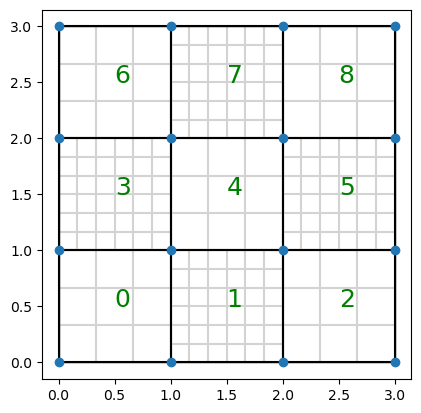

In [5]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
deg=1
elim=True

for i in range(1):
    M = checkerboard(deg,3*2**i,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
    t=time.time()
    I = IetiDP(MP, dir_data = {0:g}, elim=elim)
    print("Initializing took "+str(time.time()-t)+" seconds.")
    t=time.time()
    I.assemble(problem='(inner(grad(u),grad(v)))* dx',f=lambda x,y: 1.)
    print("Assembling took "+str(time.time()-t)+" seconds.")
    #print(I.rhsk)
    #print(I.Ak)
    t = time.time()
    I.construct_primal_constraints(redundant=True)
    I.construct_primal_basis()
    print("Constructing primal system took "+str(time.time()-t)+" seconds.")
    t = time.time()
    F,b= I.compute_F()
    #print(b)
    F_mat = F@np.eye(len(b))
    print("Constructing Schur complement operator took "+str(time.time()-t)+" seconds.")
    t=time.time()
    MsD = I.MsD(new=False)
    #MsD_mat = MsD@np.eye(len(b))
    print("Constructing preconditioner took "+str(time.time()-t)+" seconds.")
    ### Solve the system with PCG
    lam, it, cond, r = solvers.pcg(F, b, x0=None, maxiter=100, P=MsD, output=1, tol=1e-6)
    #cond = algebra.condest(MsD@F_mat)
    #print(cond,((sqrt(cond)-1)/(sqrt(cond)+1))**it)
    #print((I.B_gamma.T@I.B_gamma))
    print("#####################################################")

In [243]:
F_mat = scipy.sparse.coo_matrix(F_mat)

In [244]:
sum(I.B.getnnz(axis=0)==2)

16

In [245]:
prim_idx = np.where(F_mat.getnnz(axis=1)==0)

In [246]:
prim_idx

(array([ 0,  2,  3,  5,  7, 10, 11, 13, 14, 16, 18, 20, 22, 24, 25, 27]),)

In [247]:
b[0]

0.5846754184147579

In [229]:
F_mat@np.ones(F_mat.shape[0])

array([ 0.     , 27.27368, 25.60794, 29.55888, 29.11457, 29.11449, 28.25077, 27.19292, 25.79606, 24.15895, 22.26879, 20.11417, 17.71331, 14.91392, 11.97209,  7.86601,  4.88686,  0.     ,  0.     , 52.40628, 54.04648, 63.73757, 65.75992, 68.4311 , 69.60833, 70.4959 , 70.8572 , 70.8572 , 70.4959 , 69.60833, 68.4311 , 65.75992, 63.73757, 54.04648, 52.40628,  0.     , 27.27368, 25.60794, 29.55888, 29.11457, 29.11449, 28.25077, 27.19292, 25.79606, 24.15895, 22.26879, 20.11417, 17.71331, 14.91392, 11.97209,  7.86601,  4.88686,  0.     ,  4.88686,  7.86601, 11.97209, 14.91392, 17.71331, 20.11417, 22.26879, 24.15895, 25.79606, 27.19292, 28.25077, 29.11449, 29.11457, 29.55888, 25.60794, 27.27368,  4.88686,  7.86601, 11.97209, 14.91392, 17.71331, 20.11417, 22.26879, 24.15895, 25.79606, 27.19292, 28.25077, 29.11449, 29.11457, 29.55888, 25.60794, 27.27368,  0.     ,  0.     , 52.40628, 54.04648, 63.73757, 65.75992, 68.4311 , 69.60833, 70.4959 , 70.8572 , 70.8572 , 70.4959 , 69.60833, 68.4311 , 65.

In [207]:
b[prim_idx]-b[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

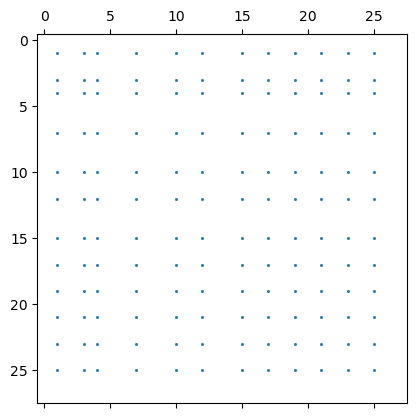

In [202]:
spy(F_mat,markersize=1)

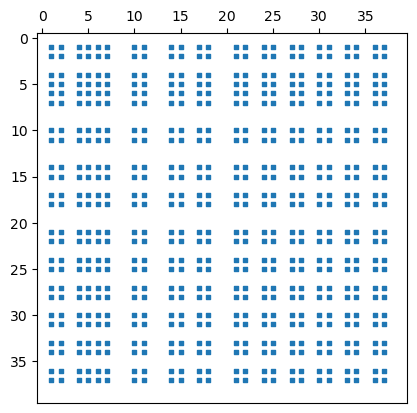

In [179]:
vis.spy(scipy.sparse.coo_matrix(F_mat))

In [158]:
I.B

<72x532 sparse matrix of type '<class 'numpy.float64'>'
	with 144 stored elements in Compressed Sparse Row format>

In [149]:
I.Ak

[<25x25 sparse matrix of type '<class 'numpy.float64'>'
 	with 361 stored elements in Compressed Sparse Row format>,
 <78x78 sparse matrix of type '<class 'numpy.float64'>'
 	with 1552 stored elements in Compressed Sparse Row format>,
 <25x25 sparse matrix of type '<class 'numpy.float64'>'
 	with 361 stored elements in Compressed Sparse Row format>,
 <78x78 sparse matrix of type '<class 'numpy.float64'>'
 	with 1552 stored elements in Compressed Sparse Row format>,
 <36x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 576 stored elements in Compressed Sparse Row format>,
 <78x78 sparse matrix of type '<class 'numpy.float64'>'
 	with 1552 stored elements in Compressed Sparse Row format>,
 <25x25 sparse matrix of type '<class 'numpy.float64'>'
 	with 361 stored elements in Compressed Sparse Row format>,
 <78x78 sparse matrix of type '<class 'numpy.float64'>'
 	with 1552 stored elements in Compressed Sparse Row format>,
 <25x25 sparse matrix of type '<class 'numpy.float64'>'
 	wi

In [131]:
sum([b.shape[1] for b in I.Bk_])

464

In [133]:
sum([c.shape[0] for c in I.Ck])

16

In [137]:
len(I.free_dofs)

448

In [147]:
!9

/bin/bash: line 1: 9: command not found


In [57]:
M = 1*(I.B_gamma==1)

In [68]:
R = scipy.sparse.lil_matrix(I.B_gamma.shape).T
B = I.B_gamma.tocsc()
for j in range(B.shape[1]):
    for ind in range(B.indptr[j],B.indptr[j+1]):
        if B.data[ind]==1:
            i=B.indices[ind]
            R[j,i]=1
            break;

In [69]:
R

<52x40 sparse matrix of type '<class 'numpy.float64'>'
	with 32 stored elements in List of Lists format>

In [71]:
(I.B_gamma@R).A

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [58]:
len(M.indices)

40

In [59]:
len(np.unique(M.indices))

32

In [25]:
idx=np.where(M.getnnz(axis=0))
d=np.zeros(M.shape[1])
d[idx] = 1/M.getnnz(axis=0)[idx]

In [54]:
#R = scipy.sparse.spdiags([d.A[0]],[0])@I.B_gamma.T
R = M.T

In [76]:
I.B_gamma@R.A

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

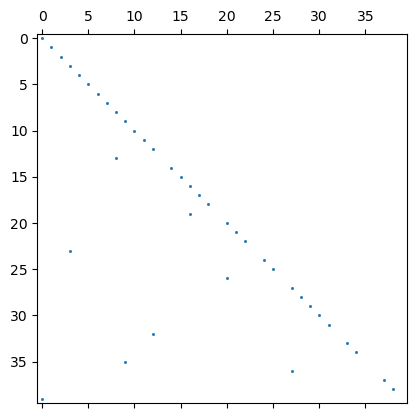

In [72]:
spy(I.B_gamma@R,markersize=1)

In [223]:
I.B_gamma@R.A

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [73]:
D = R@R.T

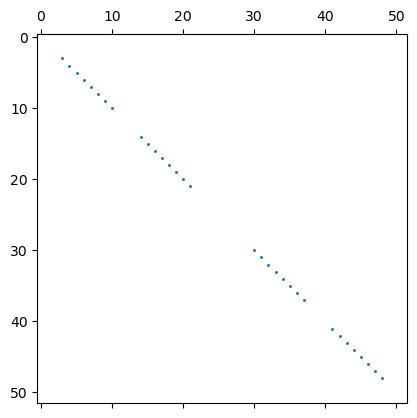

In [32]:
spy(D,markersize=1)

In [33]:
D.data

array([1. , 1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 0.5, 0.5, 1. , 1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 1. , 1. , 0.5, 1. , 1. , 1. , 1. ])

In [74]:
scipy.sparse.linalg.norm(I.B_gamma@R-scipy.sparse.identity(I.B_gamma.shape[0]))

4.0

In [75]:
scipy.sparse.linalg.norm(I.B_gamma@D@I.B_gamma.T@I.B_gamma-I.B_gamma)

5.656854249492381

In [83]:
A = np.array([[1,2,3,0,0,0],[4,5,6,0,0,0],[0,0,0,7,8,9],[0,0,0,10,11,12]])

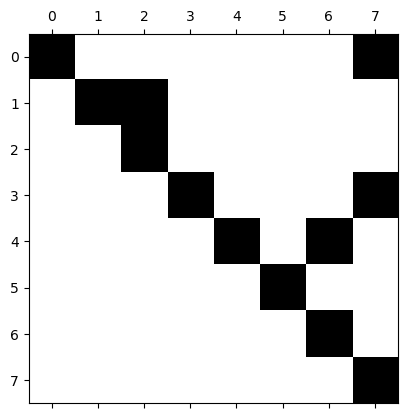

In [117]:
R = np.linalg.pinv(I.B_gamma.A)
spy(I.B_gamma@R)

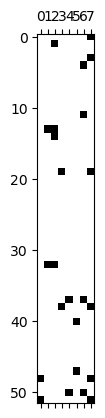

In [119]:
spy(R)

In [121]:
I.B_gamma.A

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. , -0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,

In [108]:
R[R<1e-6]=0

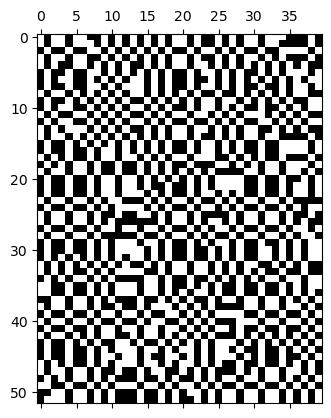

In [109]:
spy(R)

In [85]:
np.linalg.pinv(A[:2,:3])

array([[-0.94444,  0.44444],
       [-0.11111,  0.11111],
       [ 0.72222, -0.22222]])

setting up constraints took 0.0803830623626709 seconds.
Basis setup took 0.012937545776367188 seconds
Initializing took 0.18391013145446777 seconds.
Assembling took 0.26899170875549316 seconds.
Constructing primal system took 0.07976388931274414 seconds.
Constructing Schur complement operator took 0.03980302810668945 seconds.
Constructing preconditioner took 0.059899330139160156 seconds.
pcg with preconditioned condition number 1.0751442811153136 stopped after 6 iterations with relres 1.3865190842962252e-07
#####################################################
setting up constraints took 0.07887506484985352 seconds.
Basis setup took 0.013785839080810547 seconds
Initializing took 0.37487077713012695 seconds.
Assembling took 0.2826578617095947 seconds.
Constructing primal system took 0.08421611785888672 seconds.
Constructing Schur complement operator took 0.045946598052978516 seconds.
Constructing preconditioner took 0.058449506759643555 seconds.
pcg with preconditioned condition number 

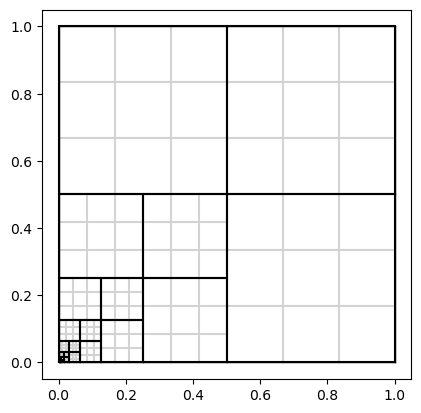

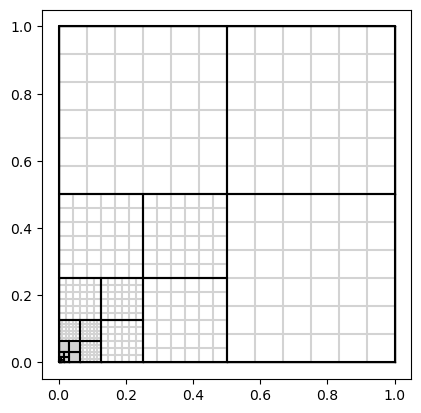

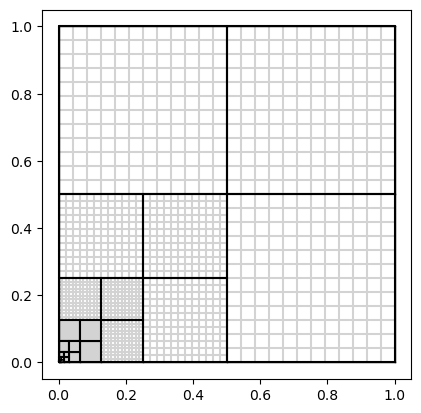

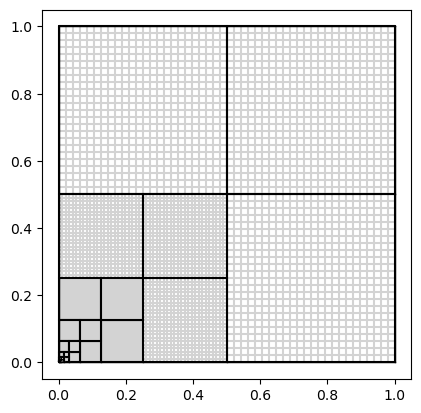

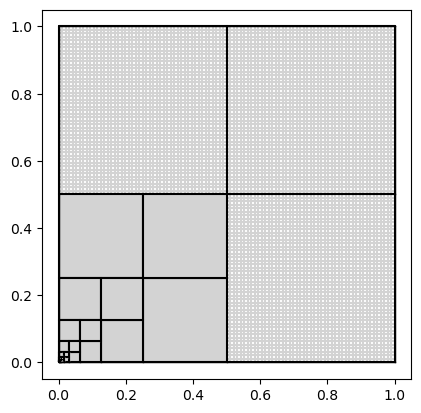

In [170]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
deg=2
elim=False

for i in range(5):
    #patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.unit_square())]
    M = Lshape(deg,3*2**i)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    MP.mesh.draw(patch_idx=0,nodes=0,knots=1)
    t=time.time()
    I = IetiDP(MP, dir_data = {0:g}, elim=elim)
    print("Initializing took "+str(time.time()-t)+" seconds.")
    t=time.time()
    I.assemble(f=lambda x,y: 1.)
    print("Assembling took "+str(time.time()-t)+" seconds.")
    #print(I.rhsk)
    #print(I.Ak)
    t = time.time()
    I.construct_primal_constraints()
    I.construct_primal_basis()
    print("Constructing primal system took "+str(time.time()-t)+" seconds.")
    t = time.time()
    F,b= I.compute_F()
    print("Constructing Schur complement operator took "+str(time.time()-t)+" seconds.")
    t=time.time()
    MsD = I.MsD()
    print("Constructing preconditioner took "+str(time.time()-t)+" seconds.")
    ### Solve the system with PCG
    lam, it, cond, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-6)
    #F_mat = F@np.eye(len(b))
    #cond = algebra.condest(MsD@F_mat)
    #print(cond,((sqrt(cond)-1)/(sqrt(cond)+1))**it)
    print("#####################################################")

In [46]:
B = np.linalg.pinv(I.B_gamma.T@I.B_gamma.A)

In [57]:
spy(D)

NameError: name 'D' is not defined

In [71]:
Fmat = F.dot(np.eye(F.shape[0]))

In [73]:
algebra.condest(MsD@Fmat)

5.271205380497244

#####################################
setting up constraints took 0.018363237380981445 seconds.
Basis setup took 0.009409666061401367 seconds
4
10
pcg with preconditioned condition number 1.1104232399228329 stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00043201446533203125 seconds for 9 patches.
setting up constraints took 0.020048141479492188 seconds.
Basis setup took 0.009725570678710938 seconds
7
26
pcg with preconditioned condition number 1.242827242377967 stopped after 6 iterations with relres 9.877262513024327e-15
Refinement took 0.000331878662109375 seconds for 9 patches.
setting up constraints took 0.023079395294189453 seconds.
Basis setup took 0.01008152961730957 seconds
8
23
pcg with preconditioned condition number 1.3131180431114824 stopped after 6 iterations with relres 7.19027091678448e-11
Refinement took 0.0003571510314941406 seconds for 9 patches.
setting up constraints took 0.029850244522094727 seconds.
Basis setup took 0.01311326026916

/home/wolfman/anaconda3/lib/python3.9/site-packages/pyiga-0.1.0-py3.9-linux-x86_64.egg/pyiga/topology.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=kwargs.get('figsize'))


21
25
pcg with preconditioned condition number 1.769266987585349 stopped after 11 iterations with relres 2.2424118613517237e-11
Refinement took 0.0003402233123779297 seconds for 9 patches.
setting up constraints took 0.03714632987976074 seconds.
Basis setup took 0.018062114715576172 seconds
24
24
pcg with preconditioned condition number 1.7675684065257513 stopped after 11 iterations with relres 8.781202012645705e-11
Refinement took 0.00039577484130859375 seconds for 9 patches.
setting up constraints took 0.06232929229736328 seconds.
Basis setup took 0.034009695053100586 seconds
25
24
pcg with preconditioned condition number 1.7590407403296329 stopped after 12 iterations with relres 2.639155553047284e-11
Refinement took 0.00043511390686035156 seconds for 9 patches.
setting up constraints took 0.11404061317443848 seconds.
Basis setup took 0.09270548820495605 seconds


KeyboardInterrupt: 

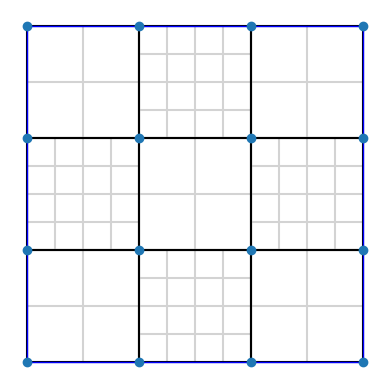

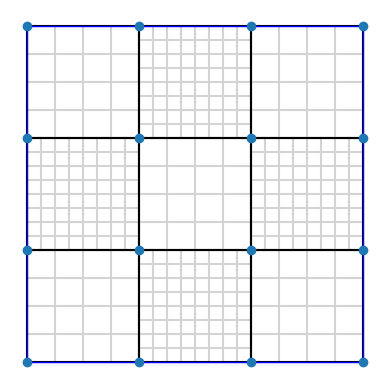

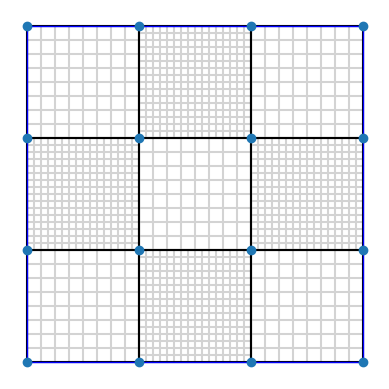

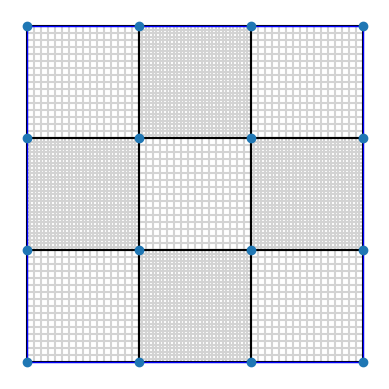

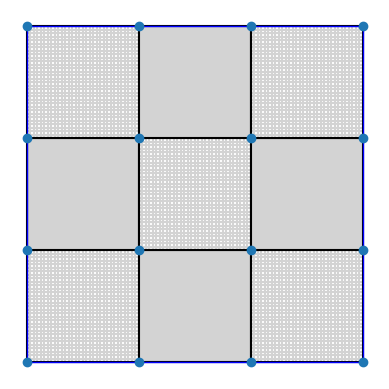

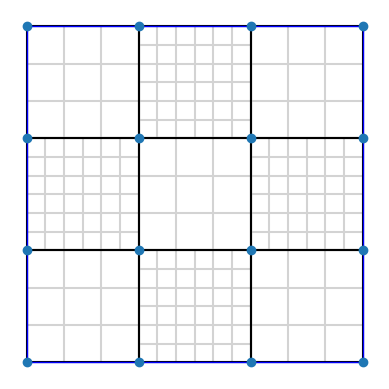

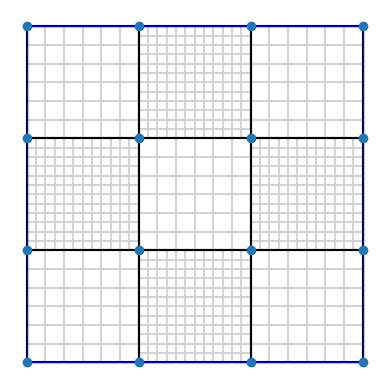

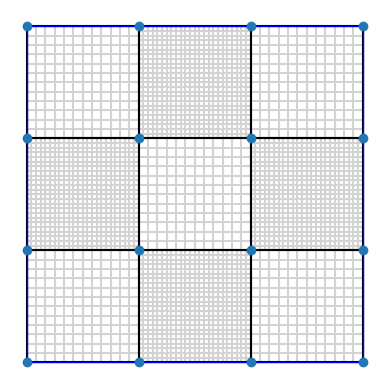

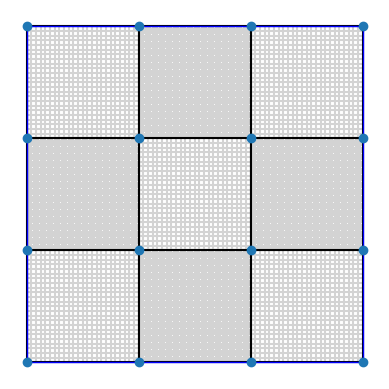

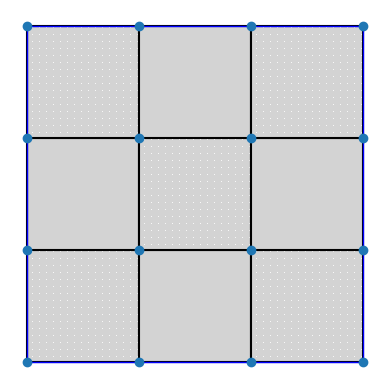

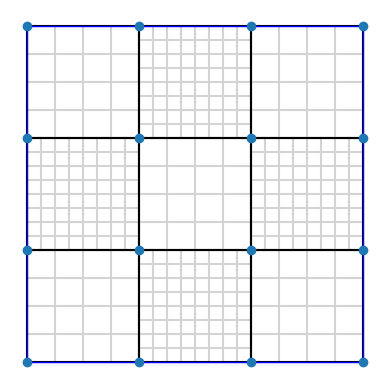

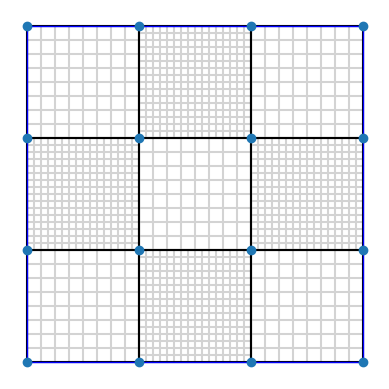

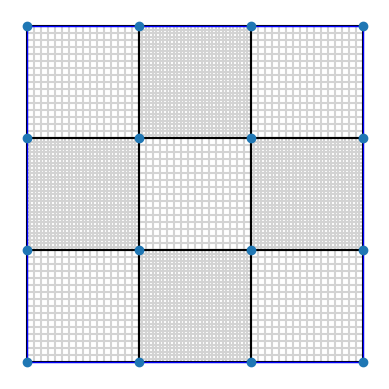

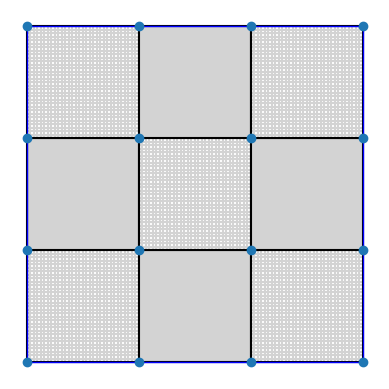

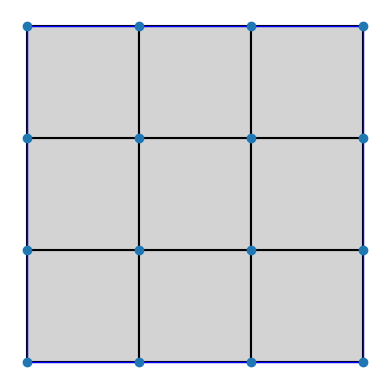

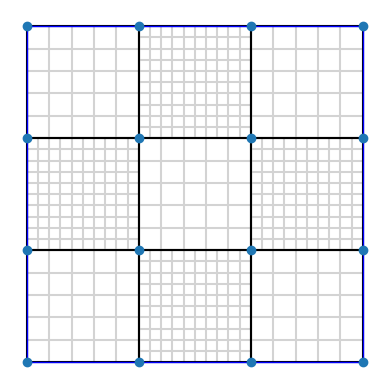

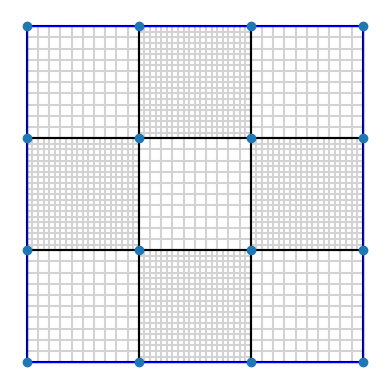

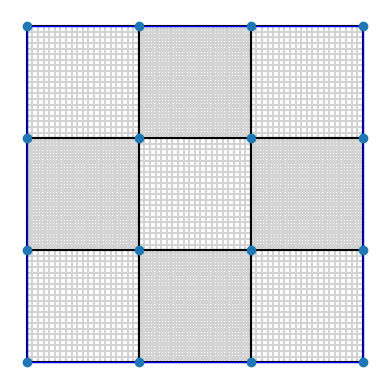

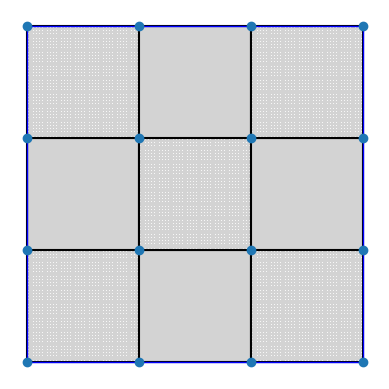

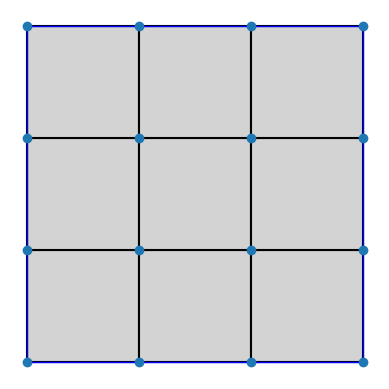

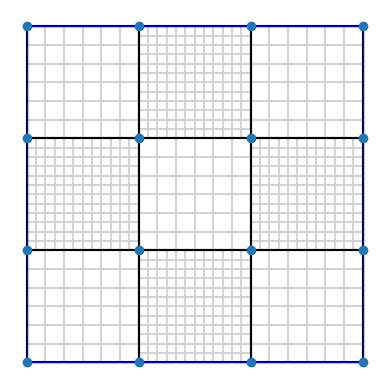

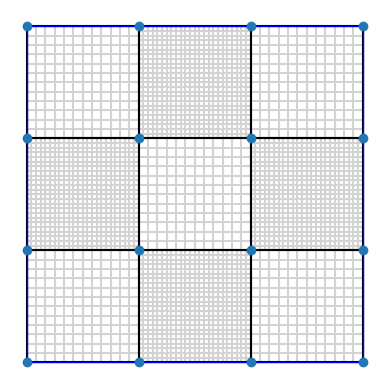

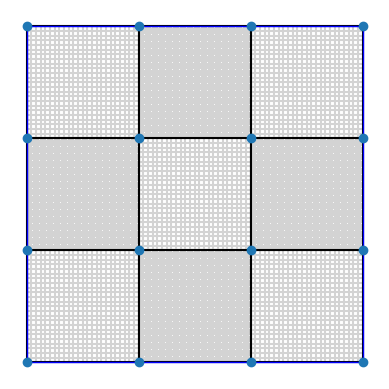

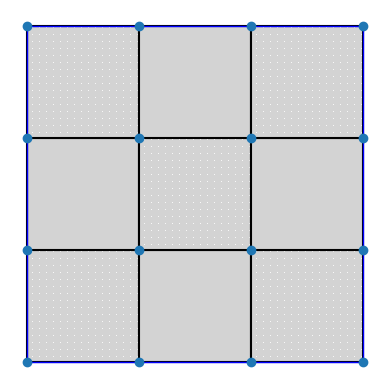

In [16]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=True)
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.017437458038330078 seconds.
Basis setup took 0.009253501892089844 seconds
pcg stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00016951560974121094 seconds for 4 patches.
setting up constraints took 0.01792740821838379 seconds.
Basis setup took 0.00933218002319336 seconds
pcg stopped after 4 iterations with relres 4.273988115438311e-17
Refinement took 0.0001652240753173828 seconds for 4 patches.
setting up constraints took 0.019681930541992188 seconds.
Basis setup took 0.009746074676513672 seconds
pcg stopped after 4 iterations with relres 9.358588499822341e-15
Refinement took 0.00015854835510253906 seconds for 4 patches.
setting up constraints took 0.021558284759521484 seconds.
Basis setup took 0.011844396591186523 seconds
pcg stopped after 4 iterations with relres 4.58228236822898e-13
Refinement took 0.00017547607421875 seconds for 4 patches.
setting up constraints took 0.02753949165344

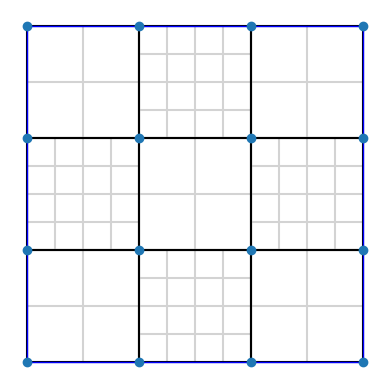

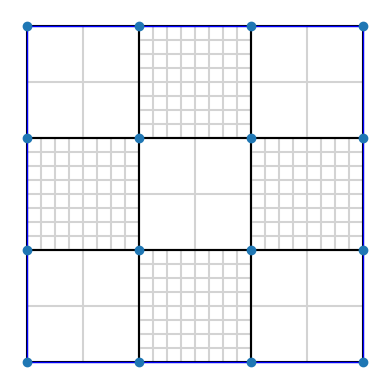

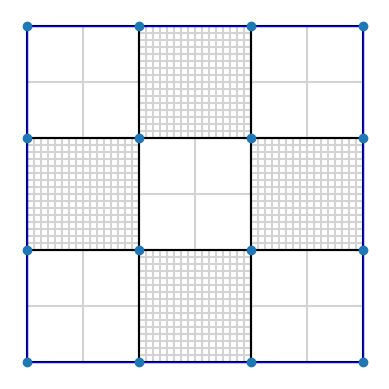

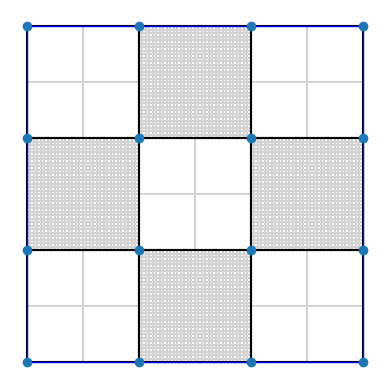

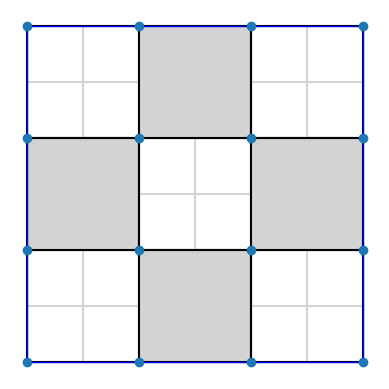

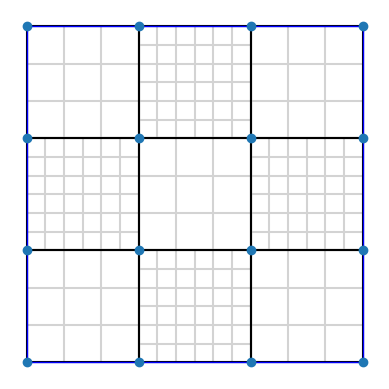

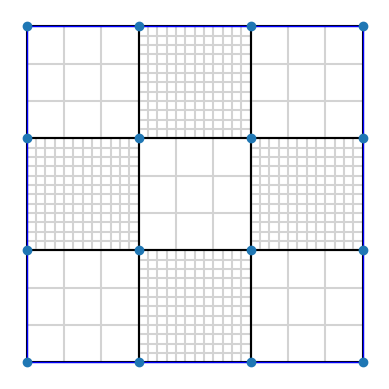

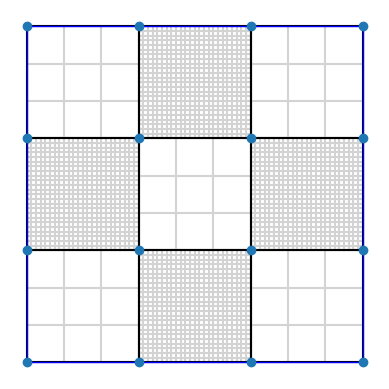

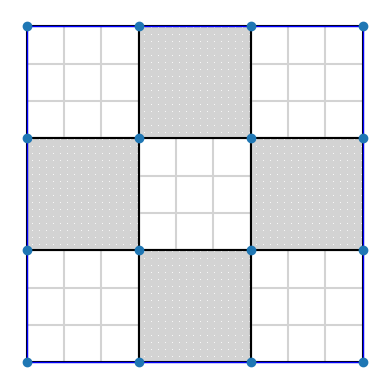

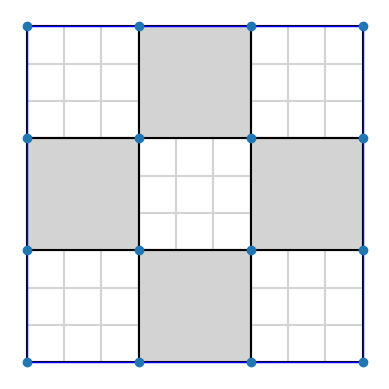

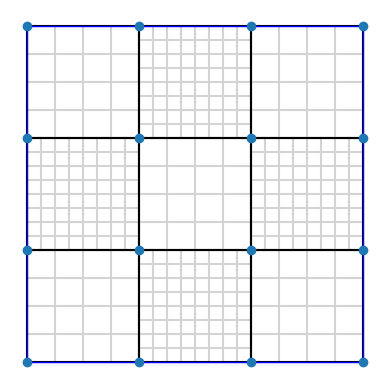

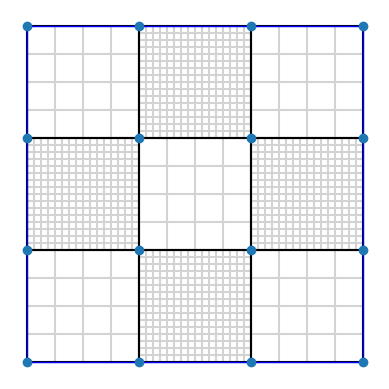

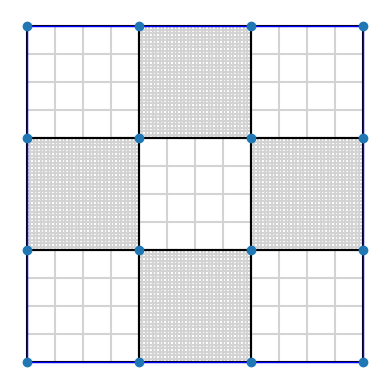

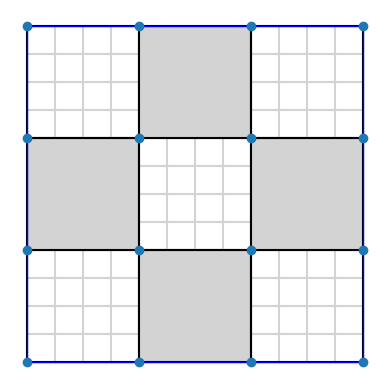

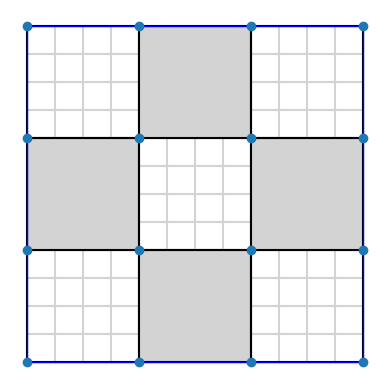

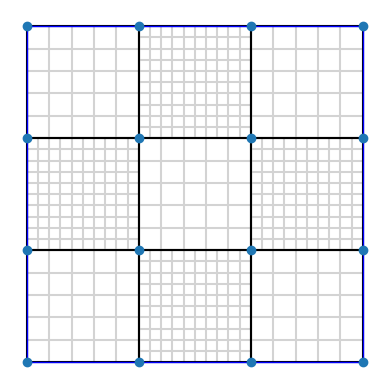

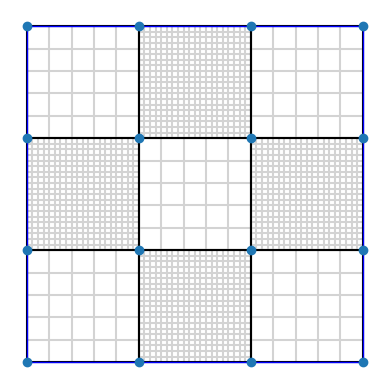

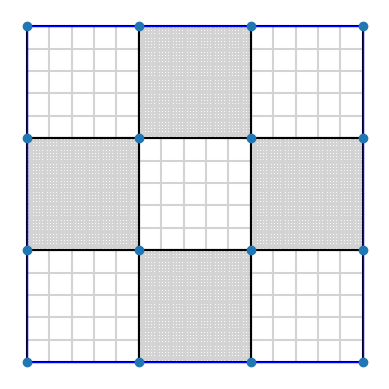

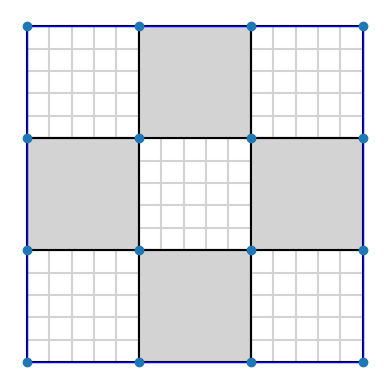

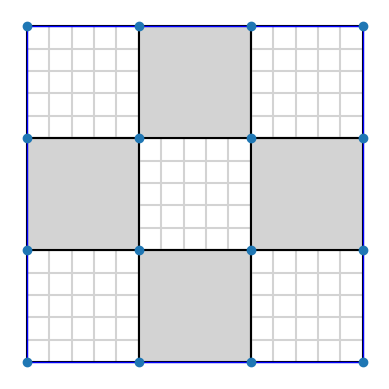

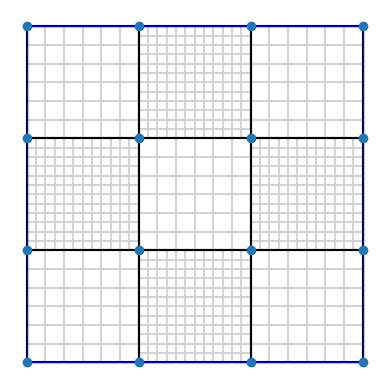

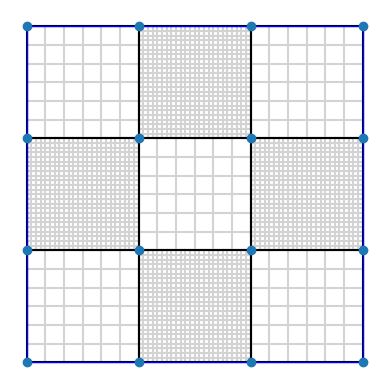

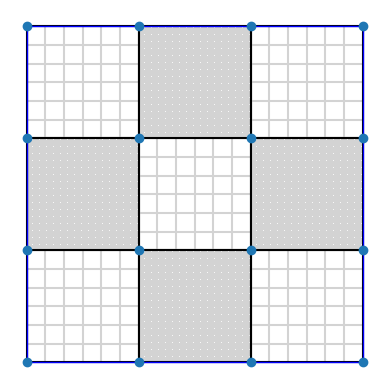

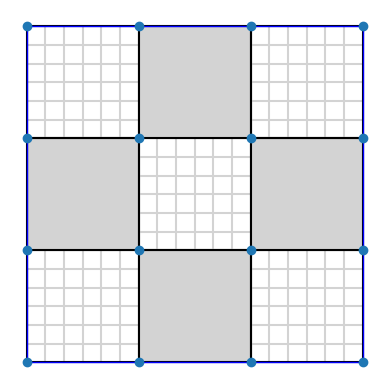

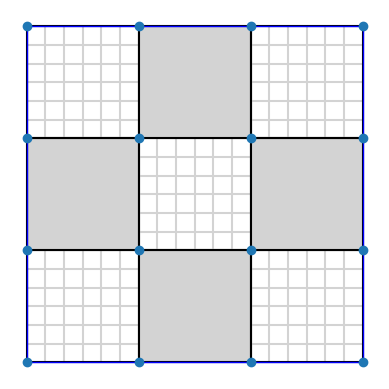

In [49]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD()
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        ###MP.h_refine(-1)
        MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

In [40]:
it

array([[1., 4., 4., 0., 0., 0.],
       [4., 6., 6., 0., 0., 0.],
       [5., 6., 7., 0., 0., 0.],
       [6., 7., 9., 0., 0., 0.],
       [7., 9., 9., 0., 0., 0.]])

In [ ]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((6,5))
it = np.zeros((6,5))
elim=True

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(6,))):
    print('#####################################')
    M = Lshape(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=False)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.08600449562072754 seconds.
Basis setup took 0.014266014099121094 seconds
pcg with preconditioned condition number 1.0972303562262358 stopped after 5 iterations with relres 2.1033830757006824e-11
Refinement took 0.0010564327239990234 seconds for 31 patches.
setting up constraints took 0.07834243774414062 seconds.
Basis setup took 0.013842582702636719 seconds
pcg with preconditioned condition number 1.671463683434546 stopped after 10 iterations with relres 4.9938397508517634e-11
Refinement took 0.0012252330780029297 seconds for 31 patches.
setting up constraints took 0.08354926109313965 seconds.
Basis setup took 0.015346527099609375 seconds
pcg with preconditioned condition number 1.2749844484684212 stopped after 13 iterations with relres 3.0492980297062935e-11
Refinement took 0.00106048583984375 seconds for 31 patches.
setting up constraints took 0.1029202938079834 seconds.
Basis setup took 0.020825624465942383 seconds
